In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix

import args

class LoadData():
    """Load graph data"""
    def __init__(self, file_path, family, samples):
        self.family = family
        self.samples = samples
        self.file_path = file_path
        self.nSample = len(samples)

    def get_adj_wgh(self):
        """generating adjacency matrix"""
        adj_orig_list =[]
        for sample in self.samples:
            f_name = self.file_path + ".".join([sample])
            adj   = np.asarray(pd.read_csv(f_name, index_col = 0, iterator = False))
            adj_orig_list.append(adj)    

        return adj_orig_list

    def get_adj_label(self):
        adj_m = self.get_adj_m()
        adj_label_list =[]
        
        for _, adj in enumerate(adj_m):
            adj_label = adj + sp.eye(adj.shape[0])
            adj_label = sparse_to_tuple(sp.coo_matrix(adj_label))
            #adj_label = sparse_to_tuple(adj_label)
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T), 
                            torch.FloatTensor(adj_label[1]), 
                            torch.Size(adj_label[2]))
            adj_label_list.append(adj_label)
        return adj_label_list

    def get_adj_norm(self):
        adj_m = self.get_adj_m()
        adj_norm_list =[]

        for _, adj in enumerate(adj_m):
            adj_norm = preprocess_graph(adj)
            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T), 
                            torch.FloatTensor(adj_norm[1]), 
                            torch.Size(adj_norm[2]))
            adj_norm_list.append(adj_norm)

        return adj_norm_list

    def get_adj_m(self):
        adj_wgh = self.get_adj_wgh()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj>0] = 1
            for i in range(38):
                adj[i, i] = 0
            for i in range(38):
                for j in range(38):
                    if adj[i, j] == 1:
                        adj[j, i] = 1
            adj_m_list.append(adj)    
        return adj_m_list

    def get_feature(self):
        """generating feature matrix X"""
        adj_wgh = self.get_adj_wgh()
        x_list = []
        for _, adj in enumerate(adj_wgh):
            x_feature  = adj
            x_feature  = csr_matrix(x_feature)
            x_feature  = sparse_to_tuple(x_feature)
            x_feature  = torch.sparse.FloatTensor(torch.LongTensor(x_feature[0].T), 
                            torch.FloatTensor(x_feature[1]), 
                            torch.Size(x_feature[2]))
            x_list.append(x_feature)
        
        return x_list


def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    
    return sparse_to_tuple(adj_normalized)

from os import walk

def get_filename(mypath):
    f = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        f.extend(filenames)
        break
    return f

class VGAE(nn.Module):
	def __init__(self, input_dim, hidden1_dim, hidden2_dim):
		super(VGAE,self).__init__()
		self.base_gcn = GraphConvSparse(input_dim, hidden1_dim)
		self.gcn_mean = GraphConvSparse(hidden1_dim, hidden2_dim, activation=lambda x:x)
		self.gcn_logstddev = GraphConvSparse(hidden1_dim, hidden2_dim, activation=lambda x:x)

	def encode(self, x, adj):
		hidden = self.base_gcn(x, adj)
		self.mean = self.gcn_mean(hidden, adj)
		self.logstd = self.gcn_logstddev(hidden, adj)
		gaussian_noise = torch.randn(x.size(0), args.hidden2_dim)
		sampled_z = gaussian_noise*torch.exp(self.logstd) + self.mean
		return sampled_z

	def forward(self, x, adj):
		Z = self.encode(x, adj)
		A_pred = dot_product_decode(Z)
		return A_pred

class GraphConvSparse(nn.Module):
	def __init__(self, input_dim, output_dim, activation = F.relu, **kwargs):
		super(GraphConvSparse, self).__init__(**kwargs)
		self.weight = glorot_init(input_dim, output_dim) 
		self.activation = activation

	def forward(self, inputs, adj):
		x = inputs
        
		x = torch.mm(x,self.weight)
		x = torch.mm(adj, x)
		outputs = self.activation(x)
		return outputs


def dot_product_decode(Z):
	A_pred = torch.sigmoid(torch.matmul(Z,Z.t()))
	return A_pred

def glorot_init(input_dim, output_dim):
	init_range = np.sqrt(6.0/(input_dim + output_dim))
	initial = torch.rand(input_dim, output_dim)*2*init_range - init_range
	return nn.Parameter(initial)

In [3]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix

import args

In [4]:
from tqdm import tqdm

samples = get_filename("./ipfdata/")
ipfdata = LoadData(file_path="./ipfdata/", family="EGF", samples=samples)

adj_label_list = ipfdata.get_adj_label()
adj_norm_list= ipfdata.get_adj_norm()
adj_wgh_list = ipfdata.get_adj_wgh()
adj_m = ipfdata.get_adj_m()
x_list = ipfdata.get_feature()

ipfmodel = VGAE(38,1,1)
optimizer = Adam(ipfmodel.parameters(), lr=args.learning_rate)

for epoch in range(10000):
# init ipfmodel and optimizer
    loss_total = 0
    for i in range(ipfdata.nSample):
        adj_wgh = adj_wgh_list[i]
        adj_norm = adj_norm_list[i]
        adj_label = adj_label_list[i]
        x_feature = x_list[i]
        
        A_pred = ipfmodel(x_feature, adj_norm)
        weight_mask = adj_label.to_dense().view(-1) == 1
        weight_tensor = torch.ones(weight_mask.size(0)) 
        
        pos_weight = float(adj_wgh.shape[0] * adj_wgh.shape[0] - adj_wgh.sum()) / adj_wgh.sum()
        norm = adj_wgh.shape[0] * adj_wgh.shape[0] / float((adj_wgh.shape[0] * adj_wgh.shape[0] - adj_wgh.sum()) * 2)
        weight_tensor[weight_mask] = pos_weight

        loss =  norm*F.binary_cross_entropy(A_pred.view(-1), adj_label.to_dense().view(-1), weight = weight_tensor)
        
        kl_divergence = 0.5/ A_pred.size(0) * (1 + 2*ipfmodel.logstd - ipfmodel.mean**2 - torch.exp(ipfmodel.logstd)**2).sum(1).mean()
        loss -= 0.5 * kl_divergence
        loss_total += loss

    loss_total = loss_total/ipfdata.nSample
    optimizer.zero_grad()
    loss_total.backward()
    optimizer.step()

    print("Loss:", loss_total, epoch)

Loss: tensor(4.2713, grad_fn=<DivBackward0>) 0
Loss: tensor(4.2841, grad_fn=<DivBackward0>) 1
Loss: tensor(4.3525, grad_fn=<DivBackward0>) 2
Loss: tensor(4.2416, grad_fn=<DivBackward0>) 3
Loss: tensor(4.1748, grad_fn=<DivBackward0>) 4
Loss: tensor(4.0970, grad_fn=<DivBackward0>) 5
Loss: tensor(3.8562, grad_fn=<DivBackward0>) 6
Loss: tensor(3.7792, grad_fn=<DivBackward0>) 7
Loss: tensor(3.5296, grad_fn=<DivBackward0>) 8
Loss: tensor(3.3509, grad_fn=<DivBackward0>) 9
Loss: tensor(3.1505, grad_fn=<DivBackward0>) 10
Loss: tensor(2.7635, grad_fn=<DivBackward0>) 11
Loss: tensor(2.5397, grad_fn=<DivBackward0>) 12
Loss: tensor(2.2921, grad_fn=<DivBackward0>) 13
Loss: tensor(2.0184, grad_fn=<DivBackward0>) 14
Loss: tensor(1.7303, grad_fn=<DivBackward0>) 15
Loss: tensor(1.5873, grad_fn=<DivBackward0>) 16
Loss: tensor(1.3056, grad_fn=<DivBackward0>) 17
Loss: tensor(1.1720, grad_fn=<DivBackward0>) 18
Loss: tensor(0.9971, grad_fn=<DivBackward0>) 19
Loss: tensor(0.9026, grad_fn=<DivBackward0>) 20
Lo

KeyboardInterrupt: 

In [5]:
samples

['010I.EGF.csv',
 '021I.EGF.csv',
 '022I.EGF.csv',
 '025I.EGF.csv',
 '034I.EGF.csv',
 '040I.EGF.csv',
 '041I.EGF.csv',
 '051I.EGF.csv',
 '053I.EGF.csv',
 '063I.EGF.csv',
 '123I.EGF.csv',
 '135I.EGF.csv',
 '138I.EGF.csv',
 '145I.EGF.csv',
 '157I.EGF.csv',
 '158I.EGF.csv',
 '166I.EGF.csv',
 '174I.EGF.csv',
 '177I.EGF.csv',
 '179I.EGF.csv',
 '209I.EGF.csv',
 '210I.EGF.csv',
 '212I.EGF.csv',
 '214I.EGF.csv',
 '221I.EGF.csv',
 '222I.EGF.csv',
 '225I.EGF.csv',
 '228I.EGF.csv',
 '29I.EGF.csv',
 '47I.EGF.csv',
 '49I.EGF.csv',
 '59I.EGF.csv']

In [14]:
x_list[1]

tensor(indices=tensor([[ 0,  0,  0,  ..., 35, 35, 35],
                       [ 0,  1,  3,  ..., 33, 34, 35]]),
       values=tensor([0.0660, 0.0741, 0.1151, 0.0658, 0.0599, 0.3172, 0.1934,
                      0.1213, 0.2215, 0.0912, 0.1326, 0.1173, 0.1163, 0.1616,
                      0.2738, 0.1131, 0.1672, 0.1960, 0.1557, 0.1389, 0.2112,
                      0.1422, 0.1316, 0.6991, 0.5675, 0.1404, 0.1350, 0.2329,
                      0.1011, 0.1235, 0.1402, 0.5085, 0.5753, 0.3121, 0.8286,
                      0.2243, 0.5121, 0.7330, 0.3346, 0.5270, 0.5833, 0.1664,
                      0.1238, 0.2229, 0.5017, 0.7394, 0.1669, 0.3319, 0.6343,
                      0.6590, 0.1279, 0.0842, 0.1585, 0.1797, 0.5381, 0.2280,
                      0.6541, 0.2877, 0.4588, 0.1376, 0.4367, 0.5669, 0.7360,
                      0.3177, 0.3417, 0.4142, 0.5397, 0.8796, 0.8278, 0.4874,
                      1.2960, 0.2795, 0.9802, 0.7221, 0.3653, 0.4499, 0.9646,
                      0.1661, 

In [ ]:
from tqdm import tqdm

samples = get_filename("./ctrldata/")
ctrldata = LoadData(file_path="./ctrldata/", family="EGF", samples=samples)

adj_label_list = ctrldata.get_adj_label()
adj_norm_list= ctrldata.get_adj_norm()
adj_wgh_list = ctrldata.get_adj_wgh()
adj_m = ctrldata.get_adj_m()
x_list = ctrldata.get_feature()

ctrlmodel = VGAE(38,1,1)
optimizer = Adam(ctrlmodel.parameters(), lr=args.learning_rate)

for epoch in range(10000):
# init ctrlmodel and optimizer
    loss_total = 0
    for i in range(ctrldata.nSample):
        adj_wgh = adj_wgh_list[i]
        adj_norm = adj_norm_list[i]
        adj_label = adj_label_list[i]
        x_feature = x_list[i]
        
        A_pred = ctrlmodel(x_feature, adj_norm)
        weight_mask = adj_label.to_dense().view(-1) == 1
        weight_tensor = torch.ones(weight_mask.size(0)) 
        
        pos_weight = float(adj_wgh.shape[0] * adj_wgh.shape[0] - adj_wgh.sum()) / adj_wgh.sum()
        norm = adj_wgh.shape[0] * adj_wgh.shape[0] / float((adj_wgh.shape[0] * adj_wgh.shape[0] - adj_wgh.sum()) * 2)
        weight_tensor[weight_mask] = pos_weight

        loss =  norm*F.binary_cross_entropy(A_pred.view(-1), adj_label.to_dense().view(-1), weight = weight_tensor)
        
        kl_divergence = 0.5/ A_pred.size(0) * (1 + 2*ctrlmodel.logstd - ctrlmodel.mean**2 - torch.exp(ctrlmodel.logstd)**2).sum(1).mean()
        loss -= 0.5 * kl_divergence
        loss_total += loss

    loss_total = loss_total/ctrldata.nSample
    optimizer.zero_grad()
    loss_total.backward()
    optimizer.step()

    print("Loss:", loss_total, epoch)

In [ ]:
torch.save(ipfmodel.state_dict(), 'ipfmodel_weights.pth')
torch.save(ctrlmodel.state_dict(), 'ctrlmodel_weights.pth')

In [2]:
class SimuData2():
    """Load graph data"""
    def __init__(self, nsamples, prob):
        self.nSample = nsamples
        self.p = prob

    def get_adj_label(self):
        adj_m = self.get_adj_m()
        adj_label_list =[]
        for _, adj in enumerate(adj_m):
            adj_label = adj + sp.eye(adj.shape[0])
            adj_label = sparse_to_tuple(sp.coo_matrix(adj_label))
            #adj_label = sparse_to_tuple(adj_label)
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T), 
                            torch.FloatTensor(adj_label[1]), 
                            torch.Size(adj_label[2]))
            adj_label_list.append(adj_label)
        return adj_label_list

    def get_adj_norm(self):
        adj_m = self.get_adj_m()
        adj_norm_list =[]

        for _, adj in enumerate(adj_m):
            adj_norm = preprocess_graph(adj)
            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T), 
                            torch.FloatTensor(adj_norm[1]), 
                            torch.Size(adj_norm[2]))
            adj_norm_list.append(adj_norm)

        return adj_norm_list

    def get_adj_m(self):
        adj_m_list =[]
        p = self.p
        for k in range(self.nSample):
            adj = np.zeros((38, 38))
            for i in range(19,38):
                for j in range(i+1, 38):
                    adj[i,j] = random.binomial(1, p)
                    adj[j,i] = adj[i,j]
            for i in range(19):
                for j in range(i+1, 19):
                    adj[i,j] = random.binomial(1, p)
                    adj[j,i] = adj[i,j]
            adj_m_list.append(adj)    
        return adj_m_list

    def get_feature(self):
        """generating feature matrix X"""
        adj_m = self.get_adj_m()
        x_list = []
        for _, adj in enumerate(adj_m):
            x_feature  = adj
            x_feature  = csr_matrix(x_feature)
            x_feature  = sparse_to_tuple(x_feature)
            x_feature  = torch.sparse.FloatTensor(torch.LongTensor(x_feature[0].T), 
                            torch.FloatTensor(x_feature[1]), 
                            torch.Size(x_feature[2]))
            x_list.append(x_feature)
        return x_list


def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    
    return sparse_to_tuple(adj_normalized)


In [5]:
import matplotlib.pyplot as plt
from numpy import random 
simudata = SimuData2(nsamples=100, prob=0.7)
adj_m = simudata.get_adj_m()
adj_label_list = simudata.get_adj_label()
adj_norm_list= simudata.get_adj_norm()
x_list = simudata.get_feature()
simumodel = VGAE(38,1,1)
optimizer = Adam(simumodel.parameters(), lr=args.learning_rate)

In [37]:
for epoch in range(10000):
    loss_total = 0
    for i in range(simudata.nSample):
        adj_wgh = adj_m[i]
        adj_norm = adj_norm_list[i]
        adj_label = adj_label_list[i]
        x_feature = x_list[i]
        
        A_pred = simumodel(x_feature, adj_norm)
        weight_mask = adj_label.to_dense().view(-1) == 1
        weight_tensor = torch.ones(weight_mask.size(0)) 
        
        pos_weight = float(adj_wgh.shape[0] * adj_wgh.shape[0] - adj_wgh.sum()) / adj_wgh.sum()
        norm = adj_wgh.shape[0] * adj_wgh.shape[0] / float((adj_wgh.shape[0] * adj_wgh.shape[0] - adj_wgh.sum()) * 2)
        weight_tensor[weight_mask] = pos_weight

        loss =  norm*F.binary_cross_entropy(A_pred.view(-1), adj_label.to_dense().view(-1), weight = weight_tensor)
        
        kl_divergence = 0.5/ A_pred.size(0) * (1 + 2*simumodel.logstd - simumodel.mean**2 - torch.exp(simumodel.logstd)**2).sum(1).mean()
        loss -= 0.5 * kl_divergence
        loss_total += loss

    loss_total = loss_total/simudata.nSample
    optimizer.zero_grad()
    loss_total.backward()
    optimizer.step()

    print("Loss:", loss_total, epoch)

Loss: tensor(1.5264, grad_fn=<DivBackward0>) 0
Loss: tensor(1.3230, grad_fn=<DivBackward0>) 1
Loss: tensor(1.3131, grad_fn=<DivBackward0>) 2
Loss: tensor(1.3450, grad_fn=<DivBackward0>) 3
Loss: tensor(1.3545, grad_fn=<DivBackward0>) 4
Loss: tensor(1.3464, grad_fn=<DivBackward0>) 5
Loss: tensor(1.3321, grad_fn=<DivBackward0>) 6
Loss: tensor(1.3133, grad_fn=<DivBackward0>) 7
Loss: tensor(1.2899, grad_fn=<DivBackward0>) 8
Loss: tensor(1.2864, grad_fn=<DivBackward0>) 9
Loss: tensor(1.2958, grad_fn=<DivBackward0>) 10
Loss: tensor(1.2884, grad_fn=<DivBackward0>) 11
Loss: tensor(1.2767, grad_fn=<DivBackward0>) 12
Loss: tensor(1.2729, grad_fn=<DivBackward0>) 13
Loss: tensor(1.2813, grad_fn=<DivBackward0>) 14
Loss: tensor(1.2513, grad_fn=<DivBackward0>) 15
Loss: tensor(1.2508, grad_fn=<DivBackward0>) 16
Loss: tensor(1.2356, grad_fn=<DivBackward0>) 17
Loss: tensor(1.2527, grad_fn=<DivBackward0>) 18
Loss: tensor(1.2507, grad_fn=<DivBackward0>) 19
Loss: tensor(1.2396, grad_fn=<DivBackward0>) 20
Lo

KeyboardInterrupt: 

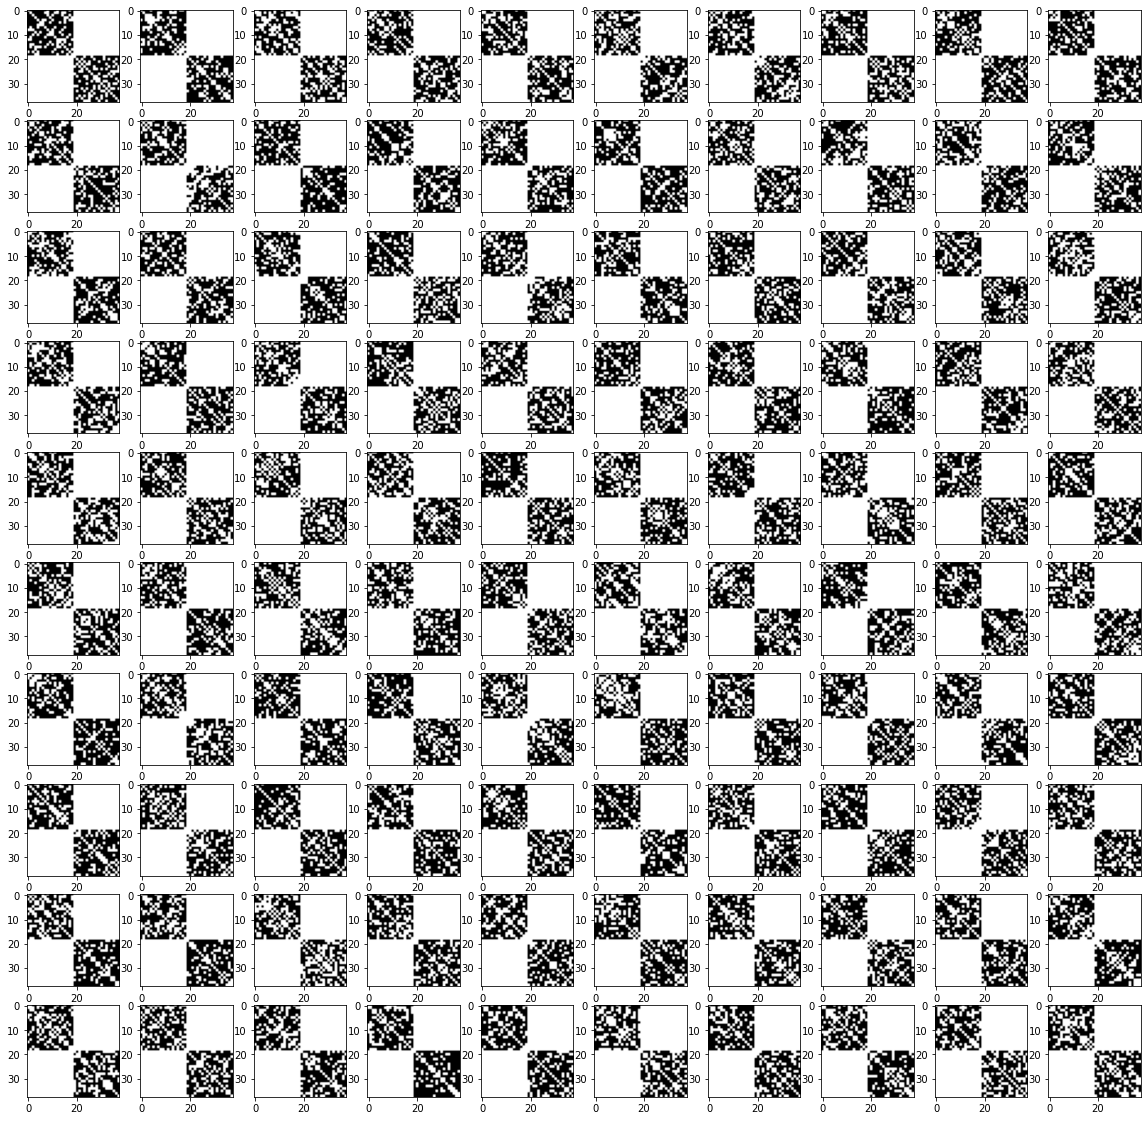

In [38]:
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(adj_m[i],cmap="Greys")

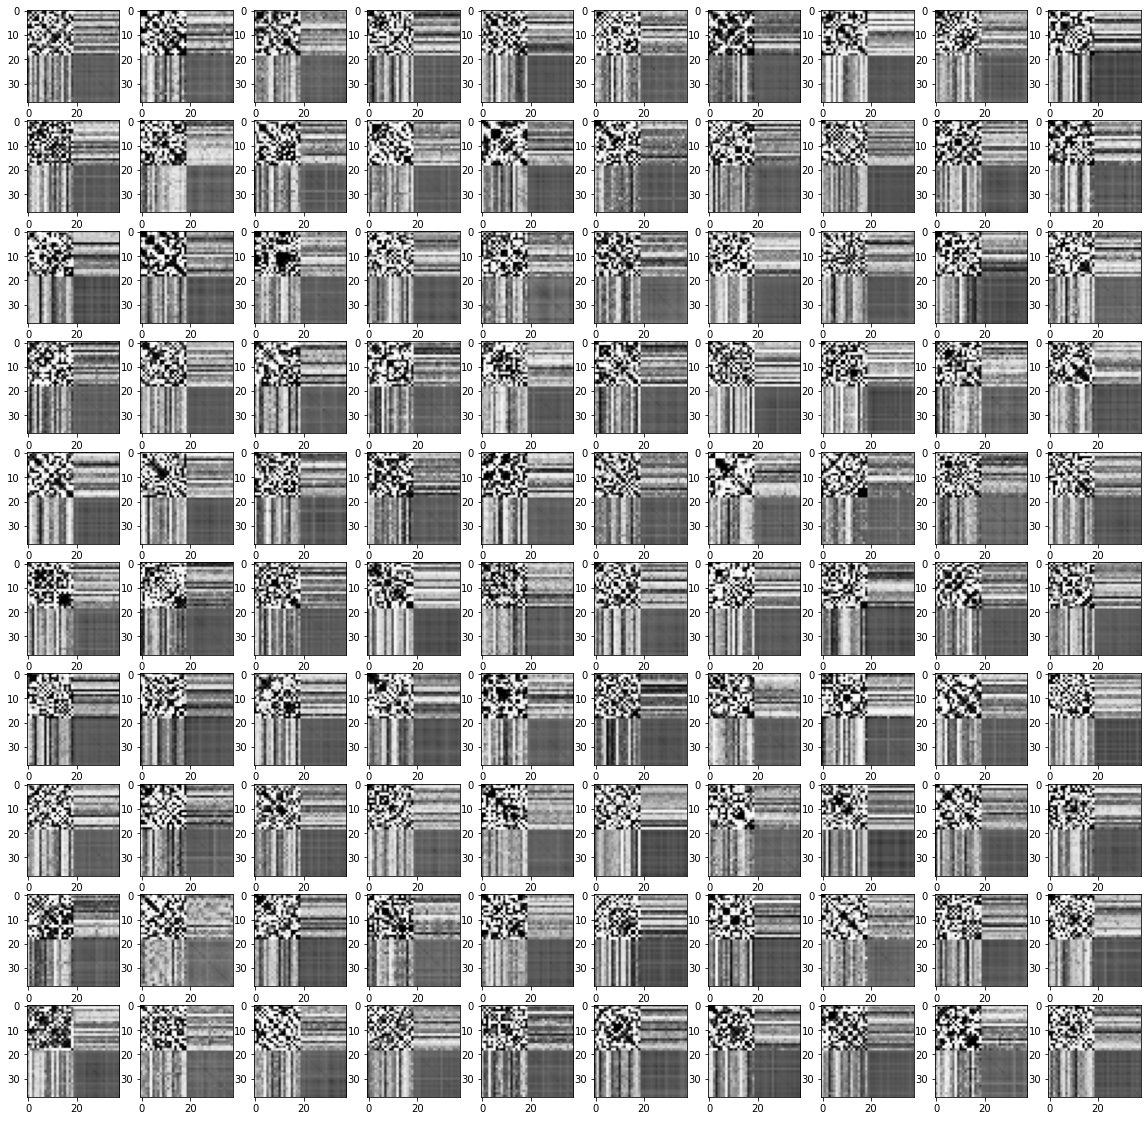

In [39]:
plt.figure(figsize=(20, 20))
plt.imshow(adj_m[1],cmap="Greys")
for i in range(100):
    adj_norm = adj_norm_list[i]
    x_feature = x_list[i]
    A_pred = simumodel(x_feature, adj_norm)
    plt.subplot(10, 10, i+1)
    plt.imshow(A_pred.detach().numpy(), cmap="Greys")